Initial attempt at saving the image from ChromeDino so that we can then try and make use of the game environment

In [1]:
import re
import time
import requests
from bs4 import BeautifulSoup
#from tqdm import tqdm, tnrange
import numpy as np
from collections import defaultdict,Counter
from scipy.misc import imread, imsave

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException

import pandas as pd
import base64
import io
from PIL import Image

from matplotlib import pyplot as plt, rcParams
from matplotlib import cm
%matplotlib inline
rcParams["figure.figsize"] = (16,12)    # Use this line to increase your figure size (optional).

# Option 2
Force Selenium to execute JavaScript to just pull the information out of the canvas tag.

In [2]:
def detect_object(img):
    x,y = np.shape(img)
    dino = img[x//2:,:x//2] #prob don't need this
    close = img[x//2:,x//2:x+30]
    return np.mean(close)
    print("Calculated {}",np.mean(close))

js_call = "return document.getElementsByClassName('runner-canvas')[0].toDataURL('image/png').substring(21);"
url = "https://chromedino.com/"
browser = webdriver.Chrome()
try:
    browser.get(url)

    body = browser.find_element_by_id('t')
    body.send_keys(Keys.ARROW_UP)
    prev_jump = None
    values = []
    while True:
        time.sleep(.15)
        b64_image = browser.execute_script(js_call)
        image = base64.b64decode(b64_image)
        buf = io.BytesIO(image)
        img = Image.open(buf).convert('LA')
        np_img = np.array(img)[:,:,0]
        new_jump = detect_object(np_img)
        if prev_jump == new_jump and new_jump > 2:
            body.send_keys(Keys.ARROW_UP)
            values.append((-1,"NEW"))
        elif new_jump > 3:
            values.append((new_jump,"J"))
            body.send_keys(Keys.ARROW_UP)
        else:
            values.append((new_jump,"N"))
        prev_jump = new_jump
except Exception as e:
    print("Errored out at step 1", e)
finally:
    browser.close() #make sure we close it when we are finished.

Errored out at step 1 argument should be a bytes-like object or ASCII string, not 'NoneType'


WebDriverException: Message: chrome not reachable
  (Session info: chrome=61.0.3163.100)
  (Driver info: chromedriver=2.33.506120 (e3e53437346286c0bc2d2dc9aa4915ba81d9023f),platform=Windows NT 6.1.7601 SP1 x86_64)


In [6]:
def find_cacti(img):
    height,width = np.shape(img)
    dino = img[height//2:,:height//2]
    vision = round(height*.8)
    field = img[vision,height//2 - width//30 - 5:]
    distance = []
    cacti_width = []
    prev_pixel = field[0]
    cur_dist = 0
    cur_width = 0
    for pixel in field:
        if prev_pixel == 0 and pixel != 0:
            distance.append(cur_dist)
            cur_dist = 0
        if prev_pixel != 0 and pixel == 0:
            cacti_width.append(cur_width)
            cur_width = 0
        if pixel == 0:
            cur_dist += 1
        else:
            cur_width += 1
        prev_pixel = pixel
    cacti_width = cacti_width[1:]
    return distance, cacti_width
    #print(img[vision,-height//2 - width//30 - 5:])

js_call = "return document.getElementsByClassName('runner-canvas')[0].toDataURL('image/png').substring(21);"
url = "https://chromedino.com/"
browser = webdriver.Chrome()
try:
    browser.get(url)

    body = browser.find_element_by_id('t')
    body.send_keys(Keys.ARROW_UP)
    prev_dist = None
    prev_width = None
    values = []
    while True:
        time.sleep(.0015)
        b64_image = browser.execute_script(js_call)
        image = base64.b64decode(b64_image)
        buf = io.BytesIO(image)
        img = Image.open(buf).convert('LA')
        np_img = np.array(img)[:,:,0]
        distances, widths = find_cacti(np_img)
        #print(distances,widths)
        if len(values) > 35:
            if values[-1] == distances and values[-2] == distances and values[-3] == distances and values[-10] == distances:
                print("GAME OVER")
                break
                #body.send_keys(Keys.ARROW_UP)
                values.append((-1,"NEW"))
            elif len(distances) != 0:
                if distances[0] < 80:
                    values.append((distances,widths,"J"))
                    #body.send_keys(Keys.ARROW_UP)
            else:
                values.append((distances,widths,"N"))
        else:
            values.append((distances,widths,"N"))
        prev_dist, prev_width = distances, widths
except Exception as e:
    print("Errored out at step 1", e)
finally:
    browser.close() #make sure we close it when we are finished.

Errored out at step 1 Message: chrome not reachable
  (Session info: chrome=61.0.3163.100)
  (Driver info: chromedriver=2.33.506120 (e3e53437346286c0bc2d2dc9aa4915ba81d9023f),platform=Windows NT 6.1.7601 SP1 x86_64)



WebDriverException: Message: chrome not reachable
  (Session info: chrome=61.0.3163.100)
  (Driver info: chromedriver=2.33.506120 (e3e53437346286c0bc2d2dc9aa4915ba81d9023f),platform=Windows NT 6.1.7601 SP1 x86_64)


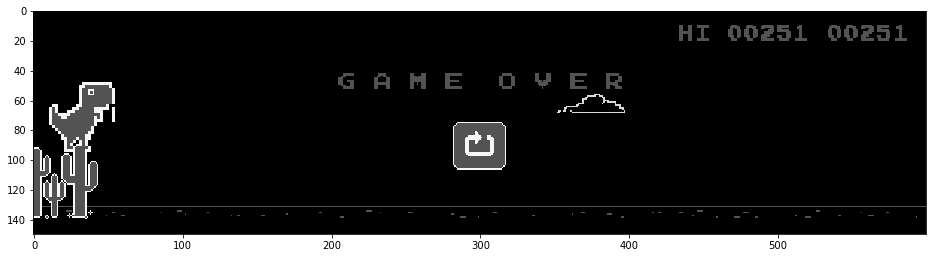

In [24]:
bird_img = np_img
plt.imshow(bird_img, cmap=cm.gray)

In [29]:
def get_cactus_height(x,y, img):
    print('here', x, y)
    while np.any(img[x,y-7:y+7]):
        x -= 1
    return x

def find_cacti(img):
    height,width = np.shape(img)
    dino = img[height//2:,:height//2]
    vision = round(height*.8)
    field = img[vision,height//2 - width//30 - 5:]
    distance = []
    cacti_width = []
    cacti_height = []
    prev_pixel = field[0]
    cur_dist = 0
    cur_width = 0
    for i,pixel in enumerate(field):
        if prev_pixel == 0 and pixel != 0:
            distance.append(cur_dist)
            print('about to break')
            cacti_height.append(get_cactus_height(vision, height//2 - width//30 - 5 + i, img))
            cur_dist = 0
        if prev_pixel != 0 and pixel == 0:
            cacti_width.append(cur_width)
            cur_width = 0
        if pixel == 0:
            cur_dist += 1
        else:
            cur_width += 1
        prev_pixel = pixel
    cacti_width = cacti_width[1:]
    return distance, cacti_width, cacti_height
    #print(img[vision,-height//2 - width//30 - 5:])

js_call = "return document.getElementsByClassName('runner-canvas')[0].toDataURL('image/png').substring(21);"
url = "https://chromedino.com/"
browser = webdriver.Chrome()
try:
    browser.get(url)

    body = browser.find_element_by_id('t')
    body.send_keys(Keys.ARROW_UP)
    prev_dist = None
    prev_width = None
    values = []
    while True:
        time.sleep(.0015)
        b64_image = browser.execute_script(js_call)
        image = base64.b64decode(b64_image)
        buf = io.BytesIO(image)
        img = Image.open(buf).convert('LA')
        np_img = np.array(img)[:,:,0]
        distances, widths, heights = find_cacti(np_img)
        print(distances, heights)
        #print(distances,widths)
        if len(values) > 70:
            if values[-1] == distances and values[-2] == distances and values[-3] == distances and values[-20] == distances:
                print("GAME OVER")
                break
                body.send_keys(Keys.ARROW_UP)
                values.append((-1,"NEW"))
            elif len(distances) != 0:
                distances_copy = distances.copy()
                for i,v in enumerate(distances_copy):
                    try:
                        if abs(distances_copy[i+1] - v) < 10:
                            distances.remove(v)
                        else:
                            break
                    except:
                        pass
                if distances[0] < 86:
                    values.append((distances,widths,"J"))
                    body.send_keys(Keys.ARROW_UP)
            else:
                values.append((distances,widths,"N"))
        else:
            values.append((distances,widths,"N"))
        prev_dist, prev_width = distances, widths
except Exception as e:
    print("Errored out at step 1", e)
finally:
    browser.close() #make sure we close it when we are finished.

[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] [

about to break
here 120 233
about to break
here 120 535
[179, 283] [91, 105]
about to break
here 120 227
about to break
here 120 529
[173, 283] [91, 105]
about to break
here 120 216
about to break
here 120 518
[162, 283] [91, 105]
about to break
here 120 210
about to break
here 120 512
[156, 283] [91, 105]
about to break
here 120 204
about to break
here 120 506
[150, 283] [91, 105]
about to break
here 120 198
about to break
here 120 500
[144, 283] [91, 105]
about to break
here 120 192
about to break
here 120 494
[138, 283] [91, 105]
about to break
here 120 186
about to break
here 120 488
[132, 283] [91, 105]
about to break
here 120 175
about to break
here 120 477
[121, 283] [91, 105]
about to break
here 120 169
about to break
here 120 471
[115, 283] [91, 105]
about to break
here 120 163
about to break
here 120 465
[109, 283] [91, 105]
about to break
here 120 157
about to break
here 120 459
[103, 283] [91, 105]
about to break
here 120 151
about to break
here 120 453
[97, 283] [91, 105]


about to break
here 120 468
[418] [91]
about to break
here 120 462
[412] [91]
about to break
here 120 456
[402] [91]
about to break
here 120 444
[390] [91]
about to break
here 120 438
[384] [91]
about to break
here 120 432
[378] [91]
about to break
here 120 426
[372] [91]
about to break
here 120 419
[365] [91]
about to break
here 120 408
[354] [91]
about to break
here 120 402
[348] [91]
about to break
here 120 396
[342] [91]
about to break
here 120 390
[336] [91]
about to break
here 120 384
[330] [91]
about to break
here 120 372
[318] [91]
about to break
here 120 366
[312] [91]
about to break
here 120 360
[306] [91]
about to break
here 120 354
[300] [91]
about to break
here 120 347
[293] [91]
about to break
here 120 341
[287] [91]
about to break
here 120 335
[281] [91]
about to break
here 120 329
[275] [91]
about to break
here 120 323
[269] [91]
about to break
here 120 317
[263] [91]
about to break
here 120 302
[248] [91]
about to break
here 120 298
[244] [91]
about to break
here 120 2

about to break
here 120 234
about to break
here 120 475
[179, 222] [91, 105]
about to break
here 120 228
about to break
here 120 469
[178, 222] [91, 105]
about to break
here 120 215
about to break
here 120 456
[165, 222] [91, 105]
about to break
here 120 209
about to break
here 120 450
[159, 222] [91, 105]
about to break
here 120 203
about to break
here 120 444
[153, 222] [91, 105]
about to break
here 120 197
about to break
here 120 438
[147, 222] [91, 105]
about to break
here 120 191
about to break
here 120 432
[141, 222] [91, 105]
about to break
here 120 185
about to break
here 120 426
[135, 222] [91, 105]
about to break
here 120 179
about to break
here 120 420
[129, 222] [91, 105]
about to break
here 120 173
about to break
here 120 414
[123, 222] [91, 105]
about to break
here 120 166
about to break
here 120 407
[116, 222] [91, 105]
about to break
here 120 154
about to break
here 120 395
[104, 222] [91, 105]
about to break
here 120 148
about to break
here 120 389
[96, 222] [91, 105]


about to break
here 120 339
[285] [91]
about to break
here 120 332
[278] [91]
about to break
here 120 326
[272] [91]
about to break
here 120 319
[265] [91]
about to break
here 120 312
[258] [91]
about to break
here 120 305
[251] [91]
about to break
here 120 298
[244] [91]
about to break
here 120 286
[232] [91]
about to break
here 120 279
[225] [91]
about to break
here 120 272
[218] [91]
about to break
here 120 259
[205] [91]
about to break
here 120 252
[198] [91]
about to break
here 120 246
[192] [91]
about to break
here 120 239
[185] [91]
about to break
here 120 232
[178] [91]
about to break
here 120 226
about to break
here 120 577
[172, 332] [91, 91]
about to break
here 120 219
about to break
here 120 570
[165, 332] [91, 91]
about to break
here 120 212
about to break
here 120 563
[158, 332] [91, 91]
about to break
here 120 206
about to break
here 120 557
[152, 332] [91, 91]
about to break
here 120 199
about to break
here 120 550
[145, 332] [91, 91]
about to break
here 120 192
about t

about to break
here 120 172
about to break
here 120 420
about to break
here 120 438
[118, 229, 1] [91, 105, 104]
about to break
here 120 166
about to break
here 120 414
about to break
here 120 432
[112, 229, 1] [91, 105, 104]
about to break
here 120 152
about to break
here 120 400
about to break
here 120 418
[98, 229, 1] [91, 105, 104]
about to break
here 120 146
about to break
here 120 394
about to break
here 120 412
[92, 229, 1] [91, 105, 104]
about to break
here 120 139
about to break
here 120 387
about to break
here 120 405
[85, 229, 1] [91, 105, 104]
about to break
here 120 126
about to break
here 120 374
about to break
here 120 392
[72, 229, 1] [91, 105, 104]
about to break
here 120 112
about to break
here 120 360
about to break
here 120 378
[62, 229, 1] [91, 105, 104]
about to break
here 120 92
about to break
here 120 340
about to break
here 120 358
[42, 229, 1] [91, 105, 104]
about to break
here 120 78
about to break
here 120 326
about to break
here 120 344
[28, 229, 1] [91, 10

about to break
here 120 107
about to break
here 120 129
about to break
here 120 143
about to break
here 120 163
[57, 3, 1, 5] [91, 93, 91, 89]
about to break
here 120 92
about to break
here 120 114
about to break
here 120 128
about to break
here 120 148
[42, 3, 1, 5] [91, 93, 91, 89]
about to break
here 120 73
about to break
here 120 95
about to break
here 120 109
about to break
here 120 129
[23, 3, 1, 5] [91, 93, 91, 89]
about to break
here 120 59
about to break
here 120 81
about to break
here 120 95
about to break
here 120 115
[9, 3, 1, 5] [91, 93, 91, 89]
about to break
here 120 68
about to break
here 120 82
about to break
here 120 102
[3, 1, 5] [93, 91, 89]
about to break
here 120 55
about to break
here 120 69
about to break
here 120 89
[3, 1, 5] [93, 91, 89]
about to break
here 120 56
about to break
here 120 76
[1, 5] [91, 89]
about to break
here 120 62
[5] [89]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []


[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] [

[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] [

[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] [

[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] [

[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] [

[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] [

[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] [

[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] [

[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] [

[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] [

WebDriverException: Message: chrome not reachable
  (Session info: chrome=61.0.3163.100)
  (Driver info: chromedriver=2.33.506120 (e3e53437346286c0bc2d2dc9aa4915ba81d9023f),platform=Windows NT 6.1.7601 SP1 x86_64)


In [89]:
find_cacti(np_img)

In [22]:
def find_bird(img):
    plt.imshow(img, cmap=cm.gray)

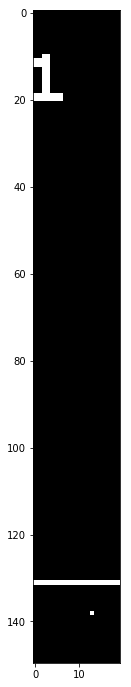

In [28]:
find_bird(bird_img[:,-20:])